1. Import & Path

In [1]:
# 05_eda.ipynb — LEVEL & RETURN EXPLORATION
# -----------------------------------------------------------------------
# Objectives:
# - Summarize level statistics (USD)
# - Plot Gold vs. BTC levels (monthly, 2020–2025)
# - Calculate monthly log-returns; store them in processed for the correlation stage
#
# Method notes:
# - Log-return_t = ln(Price_t) - ln(Price_{t-1})
# - References: pandas .diff(), NumPy np.log

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

INT  = Path("data/interim")
PROC = Path("data/processed"); PROC.mkdir(parents=True, exist_ok=True)
FIG  = Path("reports/figures"); FIG.mkdir(parents=True, exist_ok=True)
TBL  = Path("reports/tables"); TBL.mkdir(parents=True, exist_ok=True)

# THEME (color-blind friendly)
mpl.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 140,
    "font.size": 12,
    "font.family": "DejaVu Sans",
    "axes.titleweight": "bold",
    "axes.grid": True,
    "grid.color": "#D0D0D0",
    "grid.linestyle": "-",
    "grid.linewidth": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "white",
    "savefig.bbox": "tight",
})

# Color-blind safe palette (Okabe-Ito/Tableau vibe)
CBLUE   = "#0072B2"
CORANGE = "#E69F00"
CRED    = "#D55E00"
CGREEN  = "#009E73"
CGRAY   = "#666666"

2. Load Merged & QC

In [2]:
merged_path = INT/"merged_gold_btc_monthly_2020_2025.csv"
assert merged_path.exists(), f"File is not exist: {merged_path}. Run step 04 first."

df = pd.read_csv(merged_path, parse_dates=["Date"]).set_index("Date").sort_index()
# Make sure index = end-month
df.index = df.index.to_period("M").to_timestamp("M")
df = df[~df.index.duplicated(keep="last")].dropna()

print("Shape:", df.shape)
print("Range:", df.index.min(), "->", df.index.max())

Shape: (67, 2)
Range: 2020-01-31 00:00:00 -> 2025-07-31 00:00:00


3. Level Summary and Line Drawing

Saved table -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\level_summary.csv


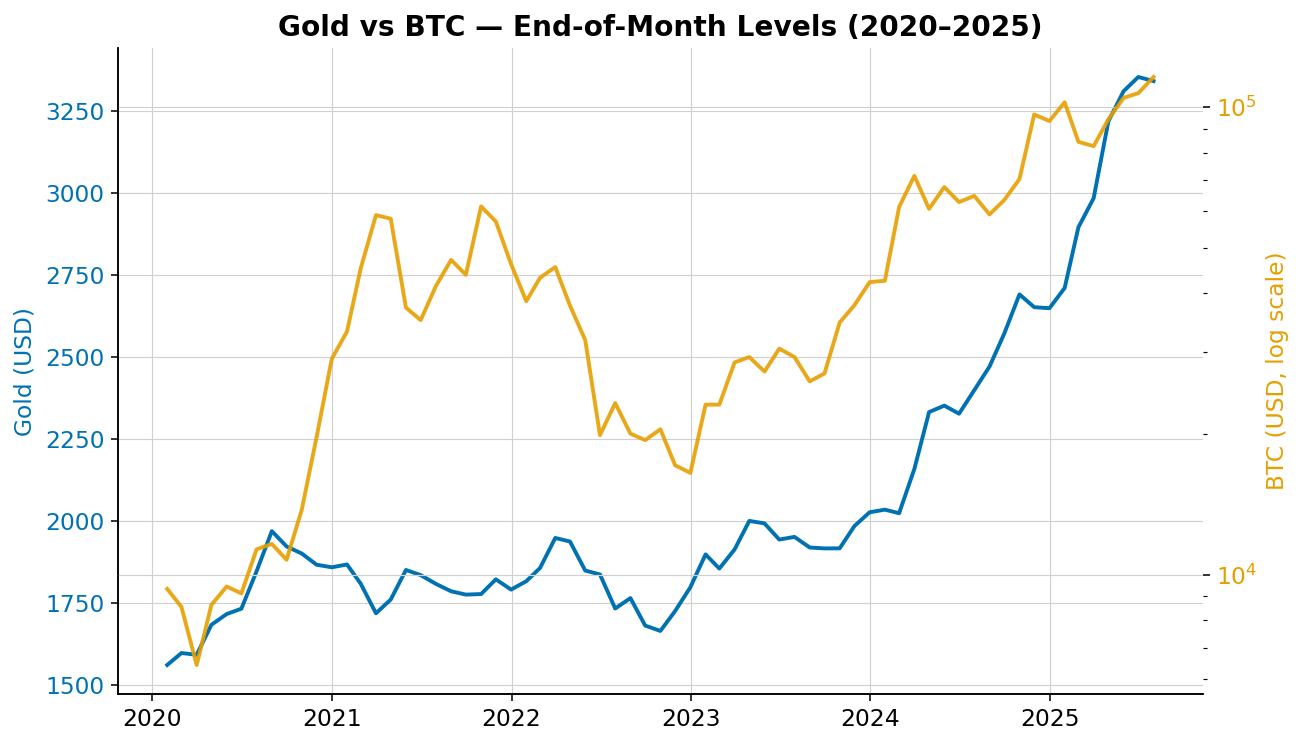

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\03_level_dualaxis.png


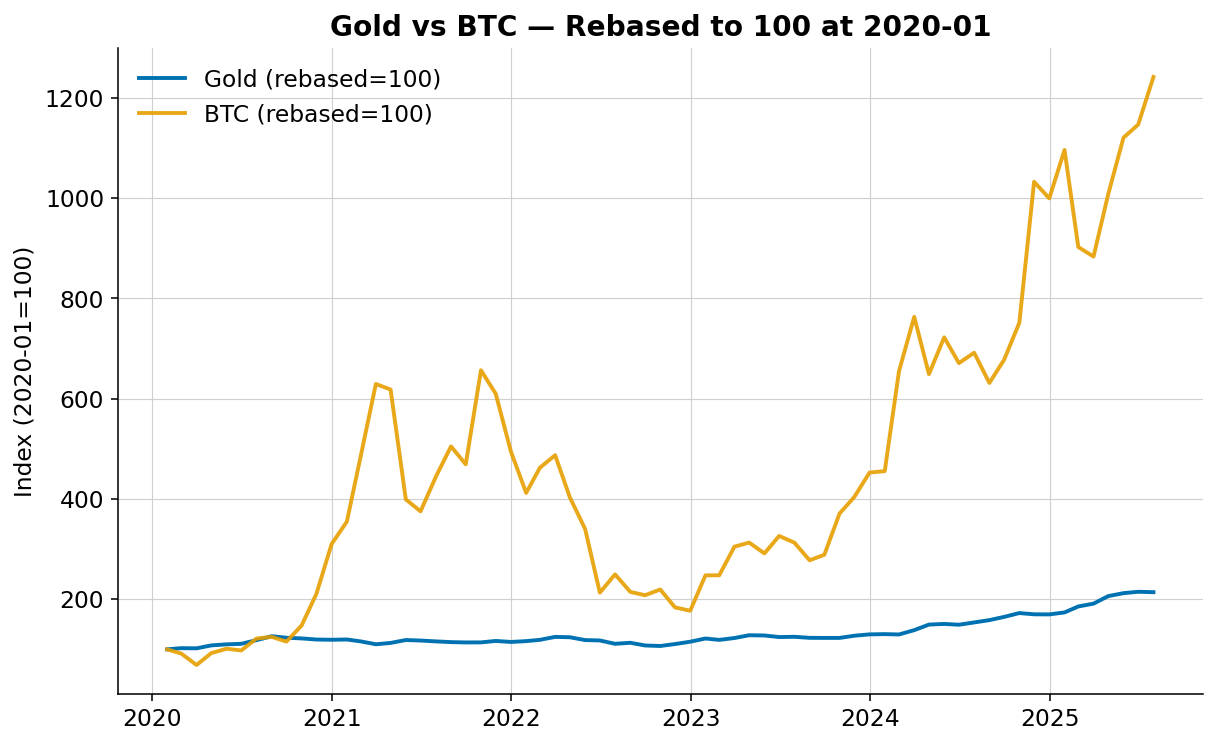

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\03_level_rebased100.png


In [3]:
# Summary level
level_summary = df.describe().round(3)
level_summary.to_csv(TBL/"level_summary.csv")
print("Saved table ->", (TBL/"level_summary.csv").resolve())

# Dual-axis EOM level (Gold left, BTC right/log) 
fig, ax1 = plt.subplots()
ax1.plot(df.index, df["Gold_USD"], color=CBLUE, label="Gold (USD)", linewidth=2)
ax1.set_ylabel("Gold (USD)", color=CBLUE)
ax1.tick_params(axis='y', labelcolor=CBLUE)
ax1.set_xlabel("")
ax1.set_title("Gold vs BTC — End-of-Month Levels (2020–2025)")

ax2 = ax1.twinx()
ax2.plot(df.index, df["BTC_USD"], color=CORANGE, label="BTC (USD)", linewidth=2, alpha=0.9)
ax2.set_ylabel("BTC (USD, log scale)", color=CORANGE)
ax2.set_yscale("log")
ax2.tick_params(axis='y', labelcolor=CORANGE)

# grid lines use the main axis
plt.savefig(FIG/"03_level_dualaxis.svg")
plt.savefig(FIG/"03_level_dualaxis.png", dpi=220)
plt.show()
print("Saved figure ->", (FIG/"03_level_dualaxis.png").resolve())

# Rebased to 100 (comparing relative dynamics)
rebased = df / df.iloc[0] * 100
fig, ax = plt.subplots()
ax.plot(rebased.index, rebased["Gold_USD"], color=CBLUE, linewidth=2, label="Gold (rebased=100)")
ax.plot(rebased.index, rebased["BTC_USD"],  color=CORANGE, linewidth=2, label="BTC (rebased=100)", alpha=0.9)
ax.set_title("Gold vs BTC — Rebased to 100 at 2020-01")
ax.set_ylabel("Index (2020-01=100)")
ax.set_xlabel("")
ax.legend(frameon=False)
plt.savefig(FIG/"03_level_rebased100.svg")
plt.savefig(FIG/"03_level_rebased100.png", dpi=220)
plt.show()
print("Saved figure ->", (FIG/"03_level_rebased100.png").resolve())


4. Calculate Monthly Log Returns & Save

Saved returns -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\data\processed\monthly_returns_gold_btc_2020_2025.csv
Saved table -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\returns_summary.csv


,Gold_ret,BTC_ret
count,66.0000,66.0000
mean,0.0115,0.0382
std,0.0315,0.1828
min,-0.0582,-0.4678
25%,-0.0095,-0.0736
50%,0.0065,0.0346
75%,0.0308,0.1339
max,0.0773,0.3864


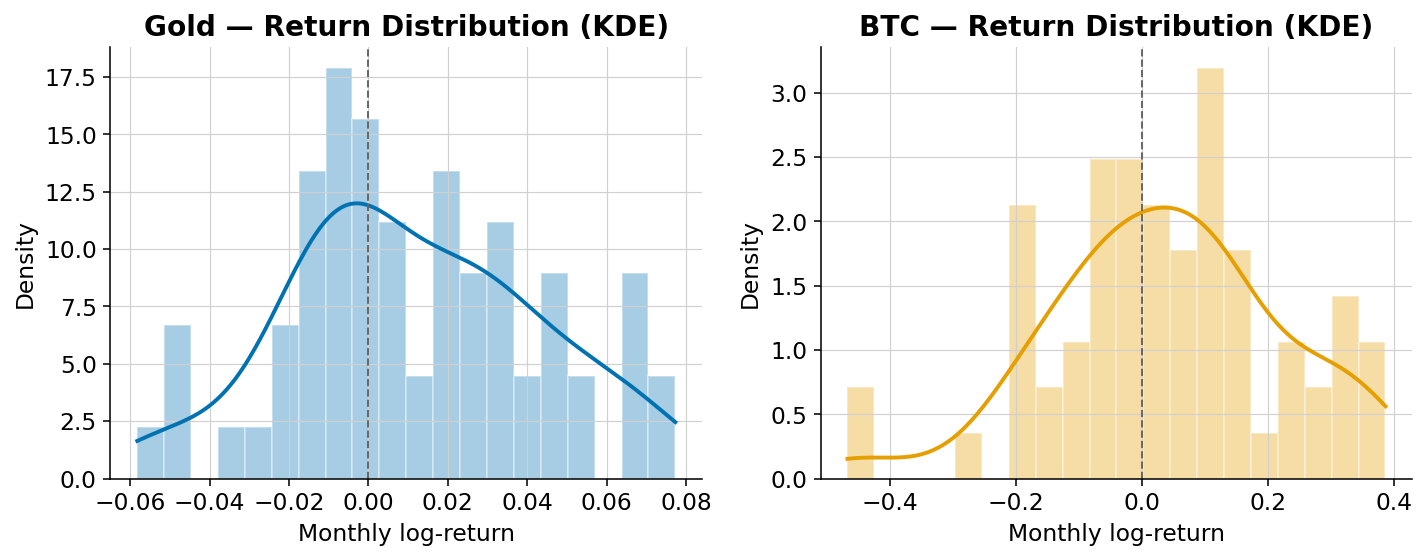

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\04_returns_hist_kde.png


In [4]:
# Calculate and save returns
ret = df.assign(
    Gold_ret = np.log(df["Gold_USD"]).diff(),
    BTC_ret  = np.log(df["BTC_USD"]).diff()
).dropna(subset=["Gold_ret","BTC_ret"])

ret.to_csv(PROC/"monthly_returns_gold_btc_2020_2025.csv", index_label="Date")
print("Saved returns ->", (PROC/"monthly_returns_gold_btc_2020_2025.csv").resolve())

ret_summary = ret[["Gold_ret","BTC_ret"]].describe().round(4)
ret_summary.to_csv(TBL/"returns_summary.csv")
print("Saved table ->", (TBL/"returns_summary.csv").resolve())
display(ret_summary)

# Distribution (Hist + simple KDE) 
from scipy.stats import gaussian_kde

def hist_kde(ax, s, color, title):
    s = s.dropna()
    ax.hist(s, bins=20, color=color, alpha=0.35, density=True, edgecolor="white")
    xs = np.linspace(s.min(), s.max(), 300)
    kde = gaussian_kde(s)
    ax.plot(xs, kde(xs), color=color, linewidth=2)
    ax.axvline(0, color=CGRAY, linestyle="--", linewidth=1)
    ax.set_title(title); ax.set_ylabel("Density"); ax.set_xlabel("Monthly log-return")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
hist_kde(axes[0], ret["Gold_ret"], CBLUE,   "Gold — Return Distribution (KDE)")
hist_kde(axes[1], ret["BTC_ret"],  CORANGE, "BTC — Return Distribution (KDE)")
plt.savefig(FIG/"04_returns_hist_kde.svg")
plt.savefig(FIG/"04_returns_hist_kde.png", dpi=220)
plt.show()
print("Saved figure ->", (FIG/"04_returns_hist_kde.png").resolve())


5. Returns (Line) and Scatter Graphs

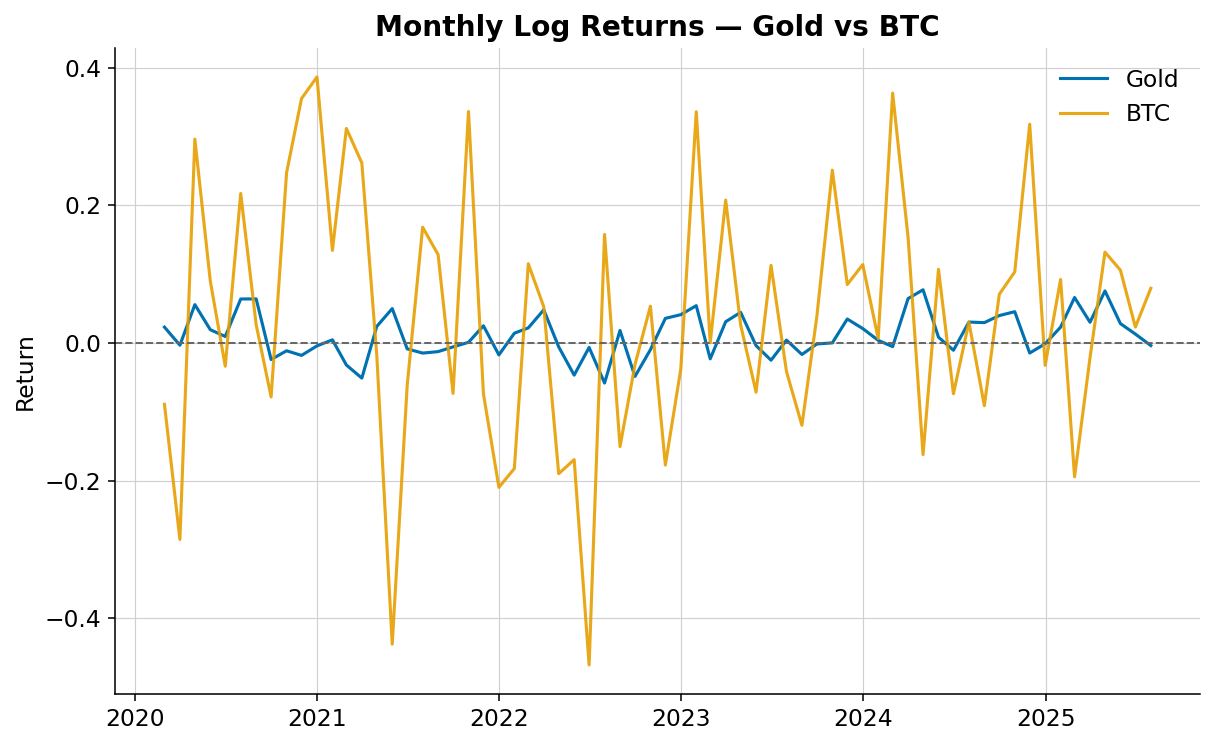

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\05_returns_overlay.png


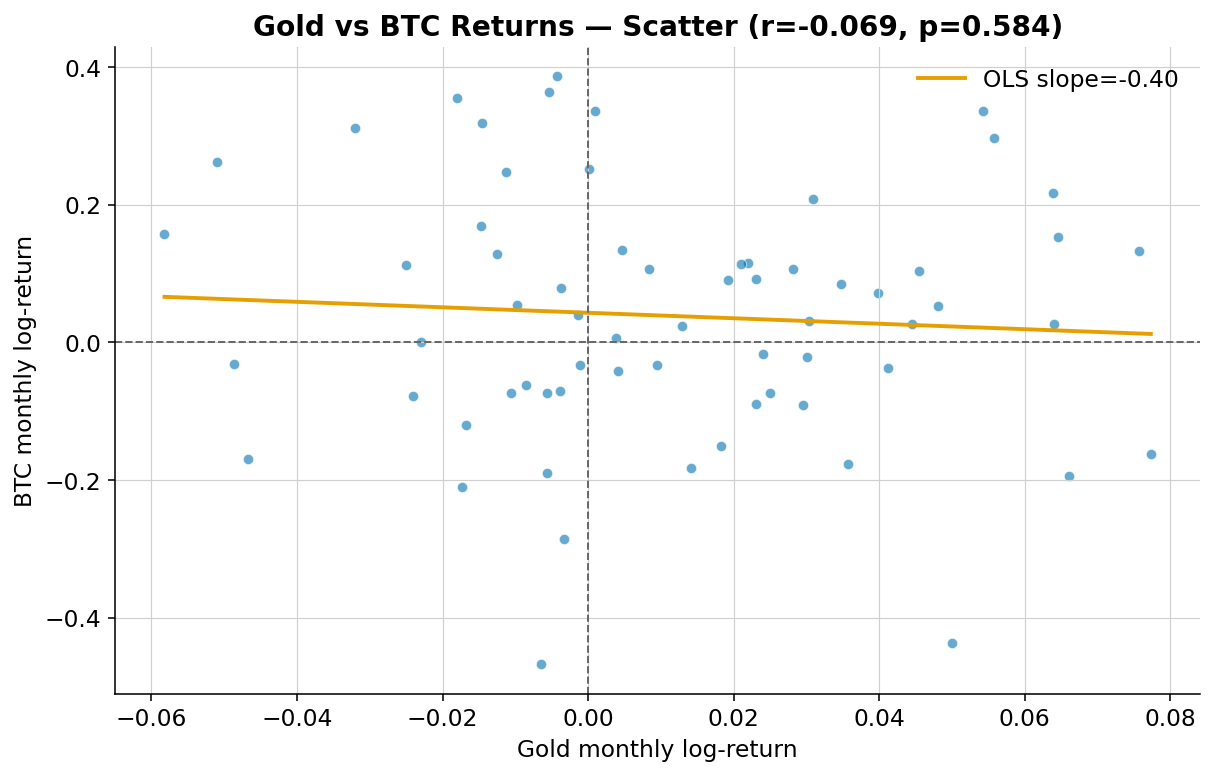

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\05_scatter_returns.png


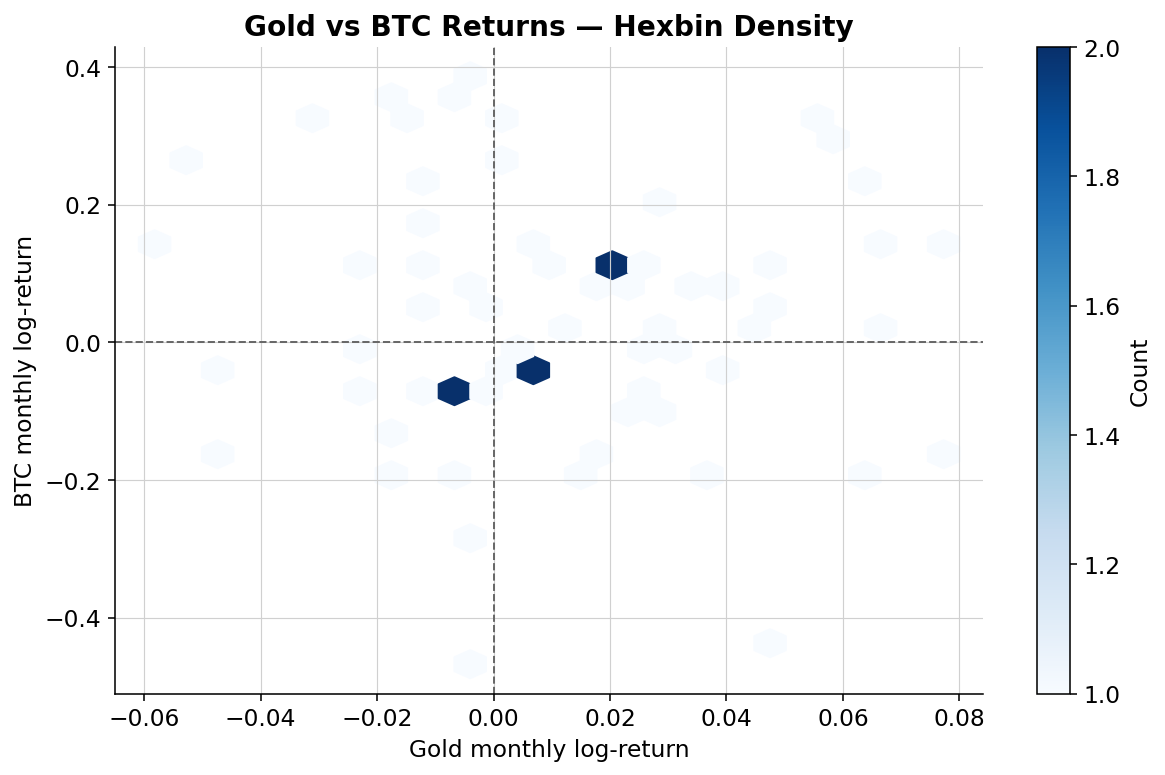

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\05_scatter_hexbin.png


In [5]:
# Overlay returns (zero line, spike highlight)
fig, ax = plt.subplots()
ax.plot(ret.index, ret["Gold_ret"], color=CBLUE, linewidth=1.6, label="Gold")
ax.plot(ret.index, ret["BTC_ret"],  color=CORANGE, linewidth=1.6, label="BTC", alpha=0.9)
ax.axhline(0, color=CGRAY, linestyle="--", linewidth=1)
ax.set_title("Monthly Log Returns — Gold vs BTC")
ax.set_ylabel("Return"); ax.set_xlabel("")
ax.legend(frameon=False)
plt.savefig(FIG/"05_returns_overlay.svg")
plt.savefig(FIG/"05_returns_overlay.png", dpi=220)
plt.show()
print("Saved figure ->", (FIG/"05_returns_overlay.png").resolve())

# Scatter + OLS trend line + r,p in the title
from scipy import stats as _stats  # avoid name clashes

r, p = _stats.pearsonr(ret["Gold_ret"], ret["BTC_ret"])
x = ret["Gold_ret"].to_numpy()
y = ret["BTC_ret"].to_numpy()
m, c = np.polyfit(x, y, 1)  # OLS linear

fig, ax = plt.subplots()
ax.scatter(x, y, s=28, alpha=0.6, color=CBLUE, edgecolor="white", linewidth=0.5)
xline = np.linspace(x.min(), x.max(), 200)
ax.plot(xline, m*xline + c, color=CORANGE, linewidth=2, label=f"OLS slope={m:.2f}")
ax.axhline(0, color=CGRAY, linestyle="--", linewidth=1)
ax.axvline(0, color=CGRAY, linestyle="--", linewidth=1)
ax.set_xlabel("Gold monthly log-return")
ax.set_ylabel("BTC monthly log-return")
ax.set_title(f"Gold vs BTC Returns — Scatter (r={r:.3f}, p={p:.3f})")
ax.legend(frameon=False)
plt.savefig(FIG/"05_scatter_returns.svg")
plt.savefig(FIG/"05_scatter_returns.png", dpi=220)
plt.show()
print("Saved figure ->", (FIG/"05_scatter_returns.png").resolve())

# Hexbin for 2D density
fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=25, cmap="Blues", mincnt=1)
ax.axhline(0, color=CGRAY, linestyle="--", linewidth=1)
ax.axvline(0, color=CGRAY, linestyle="--", linewidth=1)
ax.set_xlabel("Gold monthly log-return")
ax.set_ylabel("BTC monthly log-return")
ax.set_title("Gold vs BTC Returns — Hexbin Density")
cb = fig.colorbar(hb, ax=ax); cb.set_label("Count")
plt.savefig(FIG/"05_scatter_hexbin.svg")
plt.savefig(FIG/"05_scatter_hexbin.png", dpi=220)
plt.show()
print("Saved figure ->", (FIG/"05_scatter_hexbin.png").resolve())


6. Additional Quality Control (QC)

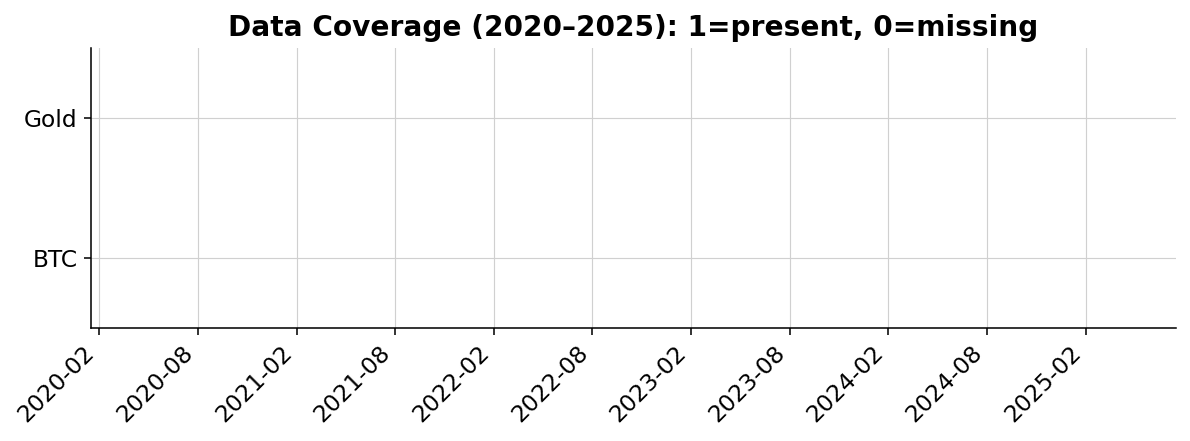

Missing months in df: 5 [Timestamp('2025-08-31 00:00:00'), Timestamp('2025-09-30 00:00:00'), Timestamp('2025-10-31 00:00:00'), Timestamp('2025-11-30 00:00:00'), Timestamp('2025-12-31 00:00:00')]
Duplicate index rows: 0


In [6]:
# QC: monthly coverage (1=present, 0=NA)
cov = pd.DataFrame({
    "Gold": ret["Gold_ret"].notna().astype(int),
    "BTC":  ret["BTC_ret"].notna().astype(int),
}, index=ret.index)

fig, ax = plt.subplots(figsize=(10, 2.6))
ax.imshow(cov.T, aspect="auto", cmap="Greys", interpolation="nearest")
ax.set_yticks([0, 1]); ax.set_yticklabels(["Gold", "BTC"])
ax.set_xticks(range(0, len(cov), 6))
ax.set_xticklabels([d.strftime("%Y-%m") for d in cov.index[::6]], rotation=45, ha="right")
ax.set_title("Data Coverage (2020–2025): 1=present, 0=missing")
plt.savefig(FIG/"06_coverage_heatmap.svg")
plt.savefig(FIG/"06_coverage_heatmap.png", dpi=220)
plt.show()

# QC: monthly coverage (1=present, 0=NA)
expected = pd.period_range("2020-01","2025-12", freq="M").to_timestamp("M")
missing = expected.difference(df.index)
dups = df.index.duplicated().sum()
print("Missing months in df:", len(missing), list(missing)[:8])
print("Duplicate index rows:", dups)
